In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2024 Technical University of Denmark
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#  Authored by: Mads Rud Larsen (DTU)
#  Edited by: Amal Alghamdi (DTU)
#  Reviewed by: Jakob Sauer Jørgensen (DTU)

# Reconstruction of fast-ion distribution function in fusion plasmas
### Mads Rud Larsen (mrula@dtu.dk)

## Introduction and forward problem formulation
Here follows a short introduction to the physical and mathematical problem that we seek to solve.

In magnetically confined fusion plasmas the most energetic positively charged ions are dubbed fast ions, and a thorough understanding of their dynamics are vital in the pursuit of commercially viable fusion energy. Fast ions are born as fusion products, needed for sustaining the high temperature of the plasma, can drive instabilities deteriorating the plasma confinement, but can also suppress turbulence. Thus, they are both a blessing and a curse, but definitely inevitable.

The fast-ion dynamics are captured in the fast-ion distribution function $f$, which is generally six dimensional, three position coordinates $\mathbf{x}$ and three velocity coordinates $\mathbf{v}$,
$$
    f=f(\mathbf{x},\mathbf{v}).
$$
Taking advantage of symmetries of the system, we can reduce the number of dimensions. The plasma is confined in a tokamak, which is a toroidally symmetric fusion device. In a cylindrical coordinate system, we can therefore ignore the toroidal angle and reduce the number of position coordinates to two $\mathbf{x}=(R,z)$, where $R$ is the [major radius](https://wiki.fusion.ciemat.es/wiki/Toroidal_coordinates). Likewise we can discard one velocity coordinate, since the magnetic moment of the fast ions is an adiabatic invariant. The magnetic moment is related to the gyromotion of the ions around the magnetic field lines, which can therefore be ignored. The velocity components are then $\mathbf{v}=(v_{\parallel},v_{\perp})$, which are the velocities parallel and perpendicular to the magnetic field line, respectively. The fast-ion distribution function can thus be expressed in 4D.

The problem is that the fast-ion distribution function cannot be measured directly. However, we can measure diagnostic signals $s$ depending on the fast-ion distribution function and invert the relation to reconstruct $f$. For interactions between a fast ion and a much less energetic target, the signal $s$ depends linearly on $f$ [1],
$$
    s(u_{1},u_{2},\varphi)=\int\int w(u_{1},u_{2},\varphi,\mathbf{x},\mathbf{v})f(\mathbf{x},\mathbf{v})\mathrm{d}\mathbf{x}\mathrm{d}\mathbf{v},
$$
   This is our forward problem. Discretizing the forward problem, we have the matrix-vector product
$$
    \mathbf{s}=W\mathbf{f}
$$
where each row in $W$ is a weight function and $\mathbf{f}$ is the vectorized fast-ion distribution function.

Now we introduce parameterization of the fast-ions distribution function. Over time, fast ions born in the plasma will collide with the bulk of the plasma and slow down until reaching a steady state distribution, which we call a slowing-down distribution function. In this numerical experiment, we run a series of simulations initializing a number of fast ions in different sources placed strategically around the plasma volume, such that the resulting slowing-down distribution functions cover the entire phase space to a large degree. The assumption is now that the true fast-ion distribution functions in an experiment lies in the phase space spanned by these slowing-down distribution functions. Thus, we take each vectorized slowing-down distribution function to be an expansion vector, such that the assumption reads
$$
    \mathbf{f}=\sum_{i=1}^{N_{\text{sd}}}c_{i}\mathbf{\psi}_{i}=\Psi\mathbf{c},
$$
where each column in the matrix $\Psi$ is a basis vector and the vector $\mathbf{c}$ contains all slowing-down coefficients [2,3]. These slowing-down distribution functions are imagined to be created by an injection of neutral particles, which ionize in the plasma. An injection of neutral particles with an energy E will result in ionized particles with energies E, E/2 and E/3, due to the physics of the ionization.

In this case we take place sources at 10 different $(R,z)$ locations inside the plasma along an injection beamline with three energy components in each location, such that we have $N_{\text{sd}}=30$ fast-ion sources. Thus, instead of reconstructing the entire phase space, we seek to only reconstruct 30 coefficients. The coefficients of the 10 sources with the same energy are expected to change smoothly along the beamline. This is true for all three sets coefficients corresponding to the three energies.

**The forward problem now reads**
$$
    \mathbf{s}=W\Psi \mathbf{c}=A\mathbf{c}.
$$
We will not go into details on how to calculate the weight matrix $W$, calculated using [4], or the slowing-down basis, calculated using [5, 6], so we just read $A=W\Psi$ from a text file, which has been created elsewhere.

We first import all the necessary libraries and classes. We also print `CUQIpy` version and set the random seed for reproducibility.

In [2]:
import numpy as np
import cuqi
from cuqi.distribution import JointDistribution, Gaussian, GMRF
import matplotlib.pyplot as plt
from cuqi.sampler import LinearRTO
from cuqi.model import LinearModel
from cuqi.geometry import Discrete
from cuqi.array import CUQIarray

In [3]:
# Set seed
np.random.seed(0)

In [4]:
print("cuqi version: ", cuqi.__version__)

cuqi version:  1.0.0


Then we load $A$, the observed noisy data, and the true coefficients, which are the true solution.

In [5]:
# Discrete forward model A = WPsi
A = np.loadtxt('WPsi_matrix_99971_Otso_Pini4_HenrikWeights_Psi1norm.txt')
# Observed noisy data s
data = np.loadtxt('signal_obs_99971_Otso_Pini4_HenrikWeights_Poisson_noise.txt')
# True slowing-down coefficients c
true_sol = np.loadtxt('true_SD_coeffs_Otso_Pini4_Psi1norm.txt')

# For technical reasons related to the generation of this data, we must reorder
# the arrays. This is not important for the user.
cols  = A.shape[1]
cc1   = range(cols)[0::3]
cc2   = range(cols)[1::3]
cc3   = range(cols)[2::3]
A_new = np.zeros(shape=A.shape)
A_new[:,0:10]  = A[:,cc1]
A_new[:,10:20] = A[:,cc2]
A_new[:,20:30] = A[:,cc3]
A = A_new
exact_sol_new = np.zeros(shape=true_sol.shape)
exact_sol_new[0:10]  = true_sol[cc1]
exact_sol_new[10:20] = true_sol[cc2]
exact_sol_new[20:30] = true_sol[cc3]
true_sol = exact_sol_new

Now we need to convert the weight matrix `A` to a `CUQIpy` model with the proper geometry, and we convert the observed data and the exact solution to CUQI arrays. Then we plot the true synthetic data and the observed noisy data. We will see that we have three detectors observing a spectrum each, where the signal from the last detector (centered at index ~300) dominates the first two (centered at indices ~60 and ~180) in absolute numbers.

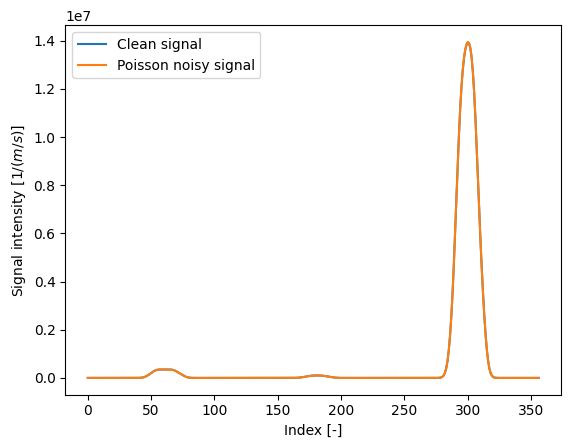

In [6]:
WPsi = LinearModel(A)
WPsi.domain_geometry = Discrete(WPsi.domain_dim)
WPsi.range_geometry = Discrete(WPsi.range_dim)
y_obs = CUQIarray(data, geometry=WPsi.range_geometry)
true_sol = CUQIarray(true_sol, geometry=WPsi.domain_geometry)

plt.figure()
plt.plot(A@true_sol)
plt.plot(y_obs)
plt.xlabel('Index [-]')
plt.ylabel('Signal intensity $[1/(m/s)]$')
plt.legend(['Clean signal','Poisson noisy signal'])

## Prepare and solve the inverse problem
For physical reasons, as explained in the introduction, we expect the first 10 slowing-down coefficients to lie on a smooth curve. Then we expect the next 10 to also lie on a smooth curve, different from the first 10 though. At last, we expect the last 10 coefficients to lie on a third smooth curve. We thus have three sets of 10 coefficients which we imagine lie on three smooth curves.

We utilize the possibility in CUQIpy to make a user defined distribution class and build a class that combines three separate distributions, each representing a coefficients set. Our user defined distribution class is called `MyDistribution` and we import it in the following cell from the accompanying file `custom_distribution.py`.

In [7]:
from custom_distribution import MyDistribution

We, therefore, create three decoupled `GMRF` prior distributions to be used in the `MyDistribution` object. This incorporates more physical prior information into the problem by imposing that the slowing-down coefficients does not fluctuate wildly. We regularize the polynomial coefficients $\mathbf{c}$ with a standard first-order Tikhonov regularization, modelled by Gaussian Markov Random Fields of order 1 with Neumann boundary conditions. The inverse problem then reads
$$
    \mathbf{c}_{\Lambda}=\min_{\mathbf{c}}\left(||\hat{\mathbf{s}}-\hat{W}\Psi\mathbf{c}||_{2}^{2}+||\Lambda L_{1}\mathbf{c}||_{2}^{2}\right),
$$
where $\Lambda$ allows for different regularization parameters on each set of 10 coefficients. The "hat" notation on $\hat{\mathbf{s}}$ and $\hat{W}$ refer to them being weighted by the data covariance matrix, which we define below. This is included in the likelihood, which goes into the posterior distribution function.

In [8]:
# Poisson noise
# Assume Poisson noise, which is actually correct.
noiselevel = np.array([np.sqrt(data)])

# Make noise floor to avoid singularities when inverting
noise_floor = np.array([(1e-3)*np.sqrt(np.max(data))*np.ones(data.shape)])
nn = np.concatenate((noiselevel, noise_floor), axis=0)

 # Make diagonal covariance matrix, i.e. uncorrelated noise
noise = np.diag(np.max(nn, axis=0))

Now we are ready to create the Bayesian problem and perform uncertainty quantification analysis. Then we plot the results.

Warning (GMRF): Periodic and Neumann boundary conditions are experimental. Sampling using LinearRTO may not produce fully accurate results.
Warning (GMRF): Periodic and Neumann boundary conditions are experimental. Sampling using LinearRTO may not produce fully accurate results.
Warning (GMRF): Periodic and Neumann boundary conditions are experimental. Sampling using LinearRTO may not produce fully accurate results.
Sample 10000 / 10000


Text(0, 0.5, 'Number of particles [-]')

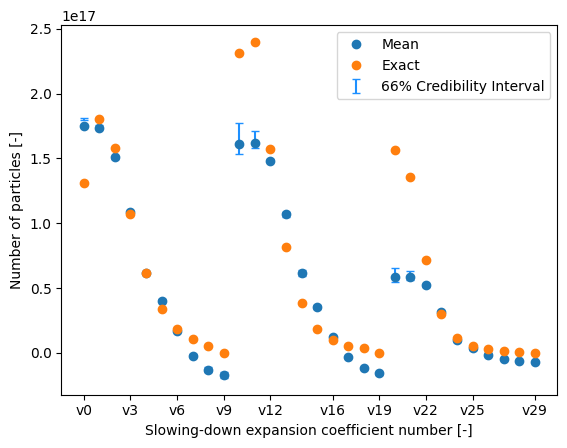

In [9]:
# Gaussian Markov Random Field (boils down to first-order Tikhonov)
# Create a distribution that is a combination of three GMRFs with Neumann
# boundary conditions.
c1 = GMRF(np.zeros(10), 1e-30, bc_type='neumann', order=1)
c2 = GMRF(np.zeros(10), 1e-30, bc_type='neumann', order=1)
c3 = GMRF(np.zeros(10), 1e-30, bc_type='neumann', order=1)
x = MyDistribution([c1, c2, c3])
y = Gaussian(mean=WPsi@x, cov=noise**2)

# Create the joint distribution
joint = JointDistribution(y, x)
# Create the posterior
posterior = joint(y=y_obs)

# If using GMRF
# Sample from the posterior using the linear RTO sampler for GMRF
sampler = LinearRTO(posterior)
posterior_samples = sampler.sample(10000)

# Plot the confidence intervals
plt.figure()
posterior_samples.plot_ci(exact=true_sol, percent=66)
plt.xlabel('Slowing-down expansion coefficient number [-]')
plt.ylabel('Number of particles [-]')

Done! As shown, it is quite hard to get good reconstructions from this problem, but we nevertheless get reconstructions which follow the correct trend of the slowing-down coefficients. In this study, the boundaries of each set of coefficients are very important as they make up a quite large proportion of the total number of coefficients. The imprint of the Neumann boundary conditions, used in the prior distributions, is evident in the mean of the posterior distribution, as can be seen on the blue markers above.

[1]: M. Salewski $\textit{et al}$, Nucl. Fusion, $\textbf{57}$ 056001 (2017)

[2]: B. Madsen $\textit{et al}$, Plasma Phys. Control. Fusion, $\textbf{62}$ 115019 (2020)

[3]: B.S. Schmidt $\textit{et al}$, Nucl. Fusion, $\textbf{63}$ 076016 (2023)

[4]: H. Järleblad $\textit{et al}$, Comput. Phys. Commun., $\textbf{294}$ 108930 (2024)

[5]: Monte Carlo Orbit-following code ASCOT
E. Hirvijoki $\textit{et al}$, Comput. Phys. Commun., $\textbf{185}$ 1310-21 (2014)

[6] J. Varje $\textit{et al}$, 2019 (arXiv:1908.02482)
